In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tigramite.data_processing as pp
import numpy as np
import scipy.optimize as sopt
import warnings
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sortabilitytime.sortability_ts import var_sortability, r2_sortability
from sortabilitytime.sortnregress_time import (
    sortnregress_ts,
    r2_sortnregress_ts,
    random_sortnregress_ts,
    random_sort_regress,
    var_sort_regress, 
    r2_sort_regress,
    __ts_graph_to_summary_graph as ts_graph_to_summary_graph,
)
from sortabilitytime.dynotears import Dynotears

import networkx as nx
from tigramite.independence_tests.parcorr import ParCorr
import warnings
import pandas as pd
from sklearn.metrics import auc, roc_curve, f1_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
"""
partially taken from:
@inproceedings{zheng2018dags,
    author = {Zheng, Xun and Aragam, Bryon and Ravikumar, Pradeep and Xing, Eric P.},
    booktitle = {Advances in Neural Information Processing Systems},
    title = {{DAGs with NO TEARS: Continuous Optimization for Structure Learning}},
    year = {2018}
}
"""


def generate_random_dag(
    n_nodes, d_inter, d_intra, tau_max, f, graph_type="erdos-renyi", decay=1.5
):
    p = d_inter / n_nodes


    w_min = 0.5
    w_max = 0.5
    if n_nodes < 2:
        raise ValueError("DAG must have at least 2 nodes")

    w_min, w_max = abs(w_min), abs(w_max)

    if w_min > w_max:
        raise ValueError(
            "Absolute minimum weight must be less than or equal to maximum weight: "
            f"{w_min} > {w_max}"
        )

    if graph_type == "erdos-renyi":
        p_threshold = float(d_intra) / (n_nodes - 1)
        p_edge = (np.random.rand(n_nodes, n_nodes) < p_threshold).astype(float)
        edge_flags = np.tril(p_edge, k=-1)

    elif graph_type == "barabasi-albert":
        m = int(round(d_intra / 2))
        edge_flags = np.zeros([n_nodes, n_nodes])
        bag = [0]
        for i in range(1, n_nodes):
            dest = np.random.choice(bag, size=m)
            for j in dest:
                edge_flags[i, j] = 1
            bag.append(i)
            bag.extend(dest)

    elif graph_type == "full":  # ignore degree
        edge_flags = np.tril(np.ones([n_nodes, n_nodes]), k=-1)

    else:
        raise ValueError(
            f"Unknown graph type {graph_type}. "
            "Available types are ['erdos-renyi', 'barabasi-albert', 'full']"
        )

    # randomly permute edges - required because we limited ourselves to lower diagonal previously
    perms = np.random.permutation(np.eye(n_nodes, n_nodes))
    edge_flags = perms.T.dot(edge_flags).dot(perms)

    # random edge weights between w_min, w_max or between -w_min, -w_max
    edge_weights = np.random.uniform(low=w_min, high=w_max, size=[n_nodes, n_nodes])
    edge_weights[np.random.rand(n_nodes, n_nodes) < 0.5] *= -1

    adj = (edge_flags != 0).astype(float) * edge_weights

    dag = nx.DiGraph(adj)

  

    link_coefs = {}

    for node in dag.nodes:
        edge_weight = random.choice((-1, 1)) * random.uniform(0.3, 0.5)
        link_coefs[node] = [
            (
                (edge[1], 0),
                edge_weight,
                f,
            )
            for edge in dag.edges(node)
        ]
        for node_2 in dag.nodes:
            if random.uniform(0, 1) < p:
                tau = random.randint(1, tau_max)
                decay_tau = 1 / decay ** (tau - 1)
                edge_weight = random.choice((-1, 1)) * random.uniform(
                    0.3 * decay_tau, 0.5 * decay_tau
                )
                link_coefs[node].insert(
                    0,
                    (
                        (node_2, -tau),
                        edge_weight,
                        f,
                    ),
                )

    return link_coefs

In [3]:

parcorr = ParCorr(
    significance="analytic",
    #                   mask_type='y'
)


In [4]:
# dont show warnings
warnings.filterwarnings("ignore")

In [5]:
lin_f = lambda x: x

In [6]:
def get_adj(links_coeffs, tau_max=None):
    if tau_max == None:
        tau_max = max(
            abs(value[i][0][1])
            for value in links_coeffs.values()
            for i in range(len(value))
        )
    n_vars = len(links_coeffs)
    adj = np.zeros((n_vars, n_vars, tau_max + 1))

    for key, value in links_coeffs.items():
        for i in range(len(value)):
            adj[value[i][0][0], key, abs(value[i][0][1])] = value[i][1]
    return adj

In [7]:
 # Generate random DAG
links_coeffs = generate_random_dag(
    n_nodes=10,
    d_intra=4,
    d_inter=1,
    tau_max=3,
    f=lin_f,
    graph_type="erdos-renyi",
)

T = 500

# Generate noises
noises = np.array(
    [
        (1.0 + 0.2 * float(j)) * np.random.randn((T + int(math.floor(0.2 * T))))
        for j in range(len(links_coeffs))
    ]
).T

data, _ = toys.structural_causal_process(
    links_coeffs, T=T, noises=noises
)

# Remove infs and nans from data
data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

a_true = get_adj(links_coeffs=links_coeffs, tau_max=3)
G = nx.DiGraph(ts_graph_to_summary_graph(a_true))
sum_adj = ts_graph_to_summary_graph(a_true)

In [8]:
data

array([[-2.0252185 , -0.5893992 ,  0.4901082 , ...,  2.6089337 ,
        -2.4586635 , -2.5997655 ],
       [-2.9077187 , -1.6176025 ,  1.899943  , ..., -2.4086611 ,
        -3.7725651 , -6.187614  ],
       [ 0.9451411 ,  3.215345  ,  0.75557435, ...,  0.92366964,
        -2.8146055 ,  0.38959908],
       ...,
       [ 3.7254233 ,  0.3735559 , -3.9768534 , ...,  5.6803    ,
         4.1251545 , -1.7364239 ],
       [ 3.6312122 ,  2.0711274 , -2.4975612 , ...,  5.332487  ,
        -1.8024733 ,  1.0166525 ],
       [ 2.0708768 ,  2.7795198 , -1.5901346 , ..., -1.7099928 ,
         2.382305  ,  5.609289  ]], shape=(500, 10), dtype=float32)

In [9]:
parcorr = ParCorr(
    significance="analytic",
    #                   mask_type='y'
)

In [10]:
# dont show warnings
warnings.filterwarnings("ignore")

In [ ]:
# Lists to store results
results = {
    "r2s": [],
    "r2s_contemp": [],
    "r2s_lagged": [],
    "var_sorts": [],
    "var_sorts_contemp": [],
    "var_sorts_lagged": [],
    "f1_dynotears": [],
    "f1_dynotears_standardized": [],
    "f1_pcmci": [],
    "f1_dynotears_inter": [],
    "f1_pcmci_inter": [],
    "f1_dynotears_lagged": [],
    "f1_pcmci_lagged": [],
    "f1_var_sortnregress": [],
    "f1_r2_sortnregress": [],
    "f1_random": [],
}
varsort_1 = 0
varsort_2 = 0
varsort_3 = 0
varsort_4 = 0
varsort_5 = 0
r2sort_1 = 0
r2sort_2 = 0
r2sort_3 = 0
r2sort_4 = 0
r2sort_5 = 0
N = 200

try:
    for i in tqdm(range(20000)):
        # Generate random DAG
        links_coeffs = generate_random_dag(
            n_nodes=10,
            d_intra=4,
            d_inter=1,
            tau_max=3,
            f=lin_f,
            graph_type="erdos-renyi",
        )

        T = 500

        # Generate noises
        noises = np.array(
            [
                (1.0 + 0.2 * float(j)) * np.random.randn((T + int(math.floor(0.2 * T))))
                for j in range(len(links_coeffs))
            ]
        ).T

        data, _ = toys.structural_causal_process(links_coeffs, T=T, noises=noises)

        # Remove infs and nans from data
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

        a_true = get_adj(links_coeffs=links_coeffs, tau_max=3)
        G = nx.DiGraph(ts_graph_to_summary_graph(a_true))
        sum_adj = ts_graph_to_summary_graph(a_true)

        # Compute various metrics
        try:
            var_sort = var_sortability(data, sum_adj)
            r2_sort = r2_sortability(data, sum_adj)
            # check to which bin the value belongs
            if var_sort < 0.2:
                if varsort_1 > N:
                    continue
                varsort_1 += 1
            elif var_sort < 0.4:
                if varsort_2 > N:
                    continue
                varsort_2 += 1
            elif var_sort < 0.6:
                if varsort_3 > N:
                    continue
                varsort_3 += 1
            elif var_sort < 0.8:
                if varsort_4 > N:
                    continue
                varsort_4 += 1
            else:
                if varsort_5 > N:
                    continue
                varsort_5 += 1

            if r2_sort < 0.2:
                if r2sort_1 > N:
                    continue
                r2sort_1 += 1
            elif r2_sort < 0.4:
                if r2sort_2 > N:
                    continue

                r2sort_2 += 1
            elif r2_sort < 0.6:
                if r2sort_3 > N:
                    continue
                r2sort_3 += 1
            elif r2_sort < 0.8:
                if r2sort_4 > N:
                    continue
                r2sort_4 += 1
            else:
                if r2sort_5 > N:
                    continue
                r2sort_5 += 1

            results["var_sorts"].append(var_sort)
            results["r2s"].append(r2_sort)
            sum_adj_lagged = ts_graph_to_summary_graph(a_true[:, :, 1:])
            var_sort_lagged = var_sortability(data, sum_adj_lagged)
            results["var_sorts_lagged"].append(var_sort_lagged)
            r2_sort_lagged = r2_sortability(data, sum_adj_lagged)
            results["r2s_lagged"].append(r2_sort_lagged)
            sum_adj_contemp = a_true[:, :, 0].copy()
            var_sort_contemp = var_sortability(data, sum_adj_contemp)
            results["var_sorts_contemp"].append(var_sort_contemp)
            r2_sort_contemp = r2_sortability(data, sum_adj_contemp)
            results["r2s_contemp"].append(r2_sort_contemp)

            # Dynotears
            dataframe = pp.DataFrame(
                data.copy(), mask=None, datatime={0: np.arange(len(data))}
            )
            dynotears = Dynotears(dataframe=dataframe)
            w_est, a_est, string_graph, a_est_dyno = dynotears.run_dynotears(
                tau_max=3, max_iter=100, w_threshold=0.1, lambda_a=0.1, lambda_w=0.1
            )

            a_true[a_true != 0] = 1
            a_est_dyno[a_est_dyno != 0] = 1

            fpr, tpr, thresholds = roc_curve(a_true.flatten(), a_est_dyno.flatten())
            f1 = f1_score(a_true.flatten(), a_est_dyno.flatten())
            results["f1_dynotears"].append(f1)
            # standardize data

            standadized = StandardScaler().fit_transform(data)
            datframe_standadized = pp.DataFrame(
                standadized.copy(), mask=None, datatime={0: np.arange(len(standadized))}
            )
            dynotears_standadized = Dynotears(dataframe=datframe_standadized)
            # reshape standardized data to fit the shape of data
            standadized = standadized.reshape(data.shape)
            w_est, a_est, string_graph, a_est_dyno_standard = (
                dynotears_standadized.run_dynotears(
                    tau_max=3, max_iter=100, w_threshold=0.1, lambda_a=0.1, lambda_w=0.1
                )
            )

            a_est_dyno_standard[a_est_dyno_standard != 0] = 1
            f1 = f1_score(a_true.flatten(), a_est_dyno_standard.flatten())

            results["f1_dynotears_standardized"].append(f1)

            a_true_contemp = a_true[:, :, 0].copy()
            a_true_contemp[a_true_contemp != 0] = 1
            fpr, tpr, thresholds = roc_curve(
                a_true_contemp.flatten(), a_est_dyno[:, :, 0].flatten()
            )
            f1 = f1_score(a_true_contemp.flatten(), a_est_dyno[:, :, 0].flatten())
            results["f1_dynotears_inter"].append(f1)

            a_true_lagged = a_true[:, :, 1:].copy()
            a_true_lagged[a_true_lagged != 0] = 1
            # fpr, tpr, thresholds = roc_curve(
            #     a_true_lagged.flatten(), a_est_dyno[:, :, 1:].flatten()
            # )
            f1 = f1_score(a_true_lagged.flatten(), a_est_dyno[:, :, 1:].flatten())
            results["f1_dynotears_lagged"].append(f1)

            # PCMCI
            pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)
            results_pcmci = pcmci.run_pcmciplus(tau_max=3, pc_alpha=0.01)
            results_pcmci["p_matrix"] = np.where(
                results_pcmci["p_matrix"] < 0.01, results_pcmci["p_matrix"], 0
            )
            a_pcmci = results_pcmci["p_matrix"]
            a_pcmci[a_pcmci != 0] = 1
            # fpr, tpr, thresholds = roc_curve(
            #     a_true.flatten(), results_pcmci["p_matrix"].flatten()
            # )
            f1 = f1_score(a_true.flatten(), a_pcmci.flatten())
            results["f1_pcmci"].append(f1)

            fpr, tpr, thresholds = roc_curve(
                a_true_contemp.flatten(), results_pcmci["p_matrix"][:, :, 0].flatten()
            )
            results["f1_pcmci_inter"].append(auc(fpr, tpr))

            # fpr, tpr, thresholds = roc_curve(
            #     a_true_lagged.flatten(), results_pcmci["p_matrix"][:, :, 1:].flatten()
            # )
            results["f1_pcmci_lagged"].append(auc(fpr, tpr))

            # Sorting and regression
            a_est_var_sortnregress = sortnregress_ts(data, tau_max=3)
            a_est_r2_sortnregress = r2_sortnregress_ts(data, tau_max=3)
            a_est_var_sortnregress[:, :, 0] = var_sort_regress(data)
            a_est_r2_sortnregress[:, :, 0] = r2_sort_regress(data)

            # fpr, tpr, thresholds = roc_curve(
            #     a_true.flatten(), a_est_r2_sortnregress.flatten()
            # )
            a_est_r2_sortnregress[a_est_r2_sortnregress != 0] = 1
            f1 = f1_score(a_true.flatten(), a_est_r2_sortnregress.flatten())
            results["f1_r2_sortnregress"].append(f1)

            # fpr, tpr, thresholds = roc_curve(
            #     a_true.flatten(), a_est_var_sortnregress.flatten()
            # )
            a_est_var_sortnregress[a_est_var_sortnregress != 0] = 1
            f1 = f1_score(a_true.flatten(), a_est_var_sortnregress.flatten())
            results["f1_var_sortnregress"].append(f1)

            # Random
            a_est_random = random_sortnregress_ts(data, tau_max=3)
            a_est_random[:, :, 0] = random_sort_regress(data)
            # fpr, tpr, thresholds = roc_curve(a_true.flatten(), a_est_random.flatten())
            a_est_random[a_est_random != 0] = 1
            f1 = f1_score(a_true.flatten(), a_est_random.flatten())
            results["f1_random"].append(f1)
        except Exception as e:
            print(f"Error occurred in iteration {i}: {e}")
            continue
finally:
    # Append results
    for key, value in results.items():
        results[key] = value

  0%|          | 22/20000 [00:32<8:12:04,  1.48s/it]

In [ ]:
# clear outpu
from IPython.display import clear_output

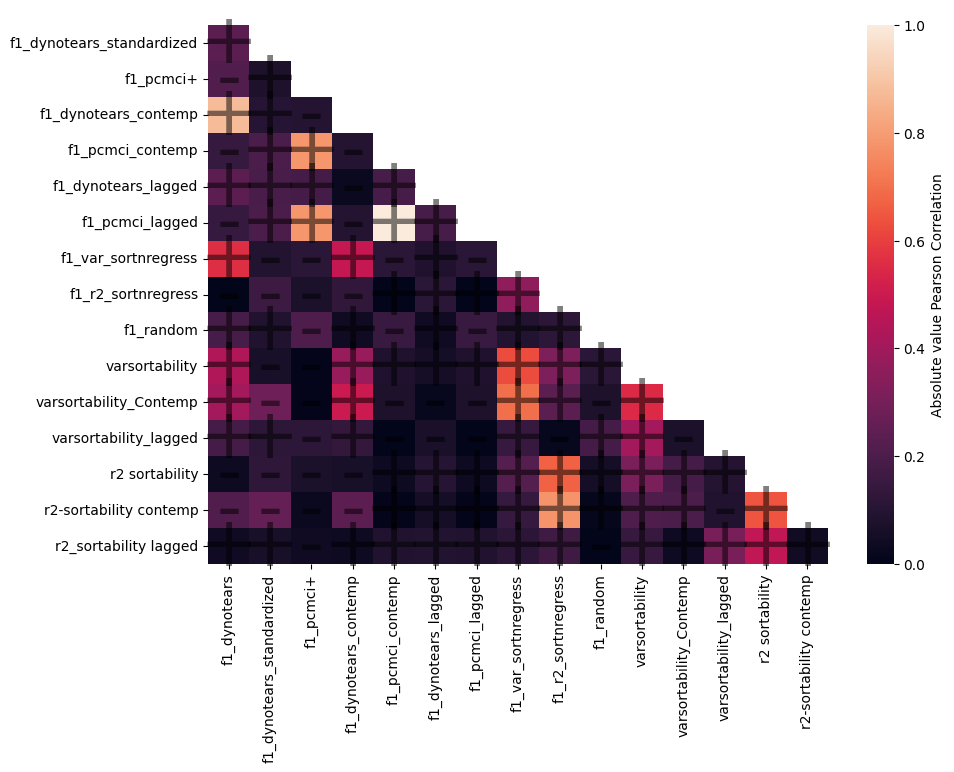

In [ ]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


def corr_matrix(df, columnames=None):
    fig = plt.figure(figsize=(10, 7))
    corr = df.corr()
    corr = corr.to_numpy()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    if columnames != None:
        assert len(columnames) == len(df.columns)
    else:
        columnames = list(df.columns)

    corr = corr[1:, :-1]
    mask = mask[1:, :-1]
    sign = np.where(corr > 0, "+", "-")
    ax = sns.heatmap(
        np.abs(corr),
        mask=mask,
        fmt=".2f",
        annot=False,
        vmin=0,
        vmax=1,
        xticklabels=columnames[:-1],
        yticklabels=columnames[1:],
        cbar_kws={"label": "Absolute value Pearson Correlation"},
    )
    ax.set_facecolor("white")
    plt.xticks(rotation=90)
    plt.yticks()

    # remove grid
    plt.grid(False)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[j, i] != 1:
                plt.text(
                    i + 0.5,
                    j + 0.5,
                    sign[j, i],
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="black",
                    alpha=0.5,
                    fontdict={"fontsize": 50},
                )


import pandas as pd


df = pd.DataFrame()


df["f1_dynotears"] = results["f1_dynotears"]
df["f1_dynotears_standardized"] = results["f1_dynotears_standardized"]
df["f1_pcmci+"] = results["f1_pcmci"]
df["f1_dynotears_contemp"] = results["f1_dynotears_inter"]
df["f1_pcmci_contemp"] = results["f1_pcmci_inter"]
df["f1_dynotears_lagged"] = results["f1_dynotears_lagged"]
df["f1_pcmci_lagged"] = results["f1_pcmci_lagged"]
df["f1_var_sortnregress"] = results["f1_var_sortnregress"]
df["f1_r2_sortnregress"] = results["f1_r2_sortnregress"]
df["f1_random"] = results["f1_random"]
df["varsortability"] = results["var_sorts"]
df["varsortability_Contemp"] = results["var_sorts_contemp"]
df["varsortability_lagged"] = results["var_sorts_lagged"]
df["r2 sortability"] = results["r2s"] 
df["r2-sortability contemp"] = results["r2s_contemp"]
df["r2_sortability lagged"] = results["r2s_lagged"]


pd.DataFrame.plot_corr = corr_matrix

corr_matrix(df)

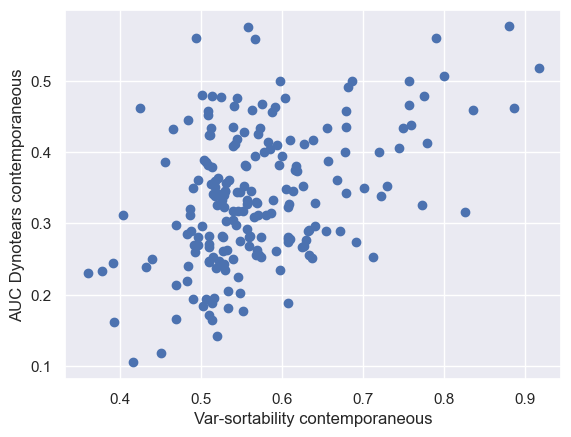

In [ ]:
sns.set_theme()

plt.scatter(df["varsortability"], df["f1_dynotears"])
plt.xlabel("Var-sortability contemporaneous")
plt.ylabel("AUC Dynotears contemporaneous")
plt.show()



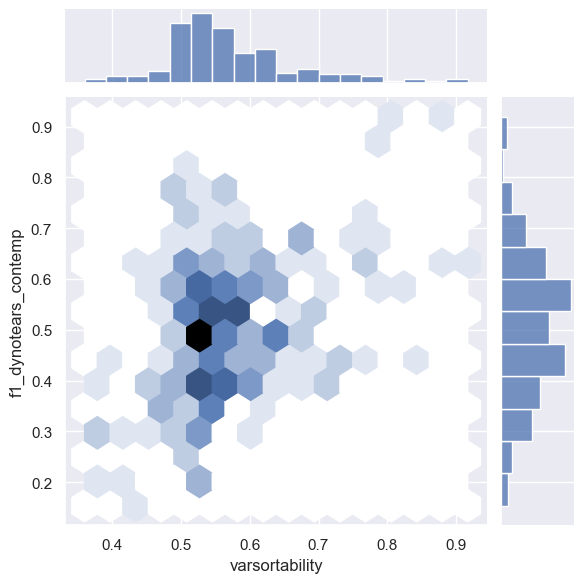

In [ ]:
# do hexagon plot with seaborn instead
sns.jointplot(data=df, x="varsortability", y="f1_dynotears_contemp", kind="hex")
plt.show()


In [ ]:
# calculate correlation between var-sortability and f1_dynotears
df["varsortability"].corr(df["f1_dynotears"])

np.float64(0.43464434601109314)

In [ ]:
# group by the bin keeping each sample

df["varsortability_bin"] = pd.cut(df["varsortability"], bins=np.arange(0, 1.1, 0.2))
# group by the bin keeping each sample
df_ = df.groupby("varsortability_bin").apply(lambda x: x)


set(df["varsortability_bin"].values )

{Interval(0.2, 0.4, closed='right'),
 Interval(0.4, 0.6, closed='right'),
 Interval(0.6, 0.8, closed='right'),
 Interval(0.8, 1.0, closed='right')}

In [ ]:
list(df["varsortability_bin"].cat.categories)[1:]

[Interval(0.2, 0.4, closed='right'),
 Interval(0.4, 0.6, closed='right'),
 Interval(0.6, 0.8, closed='right'),
 Interval(0.8, 1.0, closed='right')]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df is your DataFrame and it contains necessary columns

sns.set_theme()

# bin the dataframe by var-sortability 0.1 to 0.2, 0.2 to 0.3 etc
df["varsortability_bin"] = pd.cut(df["varsortability"], bins=np.arange(0.2, 1.1, 0.2))

# group by the bin keeping each sample
df_ = df.groupby("varsortability_bin").apply(lambda x: x.sample(30))

# Initialize the plot
plt.figure(figsize=(10, 6))

# Define boxplot colors and labels
boxplot_colors = ["blue", "orange", "red", "green", "yellow"]

boxplot_colors = ["#FF9999", "#FFB366", "#99FF99", "#6666FF"]
boxplot_labels = ["DYNOTEARS", "DYNOTEARS Standardised", "PCMCI+", "Var-sortnregress", "Random Regress"]

# Initialize legend handles and labels lists
legend_handles = []
legend_labels = []

# Loop through each boxplot
for i, (color, label) in enumerate(zip(boxplot_colors, boxplot_labels)):
    sns.boxplot(
        data=df_,
        x="varsortability_bin",
        y=[
            "f1_dynotears",
            "f1_dynotears_standardized",
            "f1_pcmci+",
            "f1_var_sortnregress",
            "f1_random",
        ][i],
        showmeans=True,
        color=color,
        meanprops={"markerfacecolor": "black", "markeredgecolor": "black"},
        width=0.1,
        positions=np.arange(4) + (i - 2) * 0.1,  # Adjust position for each boxplot
    )
    # Append handles and labels for each boxplot to the legend lists
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
    legend_labels.append(label)

# Add legend with custom handles and labels
plt.legend(handles=legend_handles, labels=legend_labels, loc="upper left")

plt.xlabel("Varsortability")
plt.ylabel("F1 Score")

# Set xticks correctly round to 2 decimal places e.g 0 to 0.2
plt.xticks(
    np.arange(4),
    [
        f"{round(i.left, 2)} to {round(i.right, 2)}"
        for i in df["varsortability_bin"].cat.categories
    ],
)
plt.savefig("figures/benchmark_var.pdf", dpi = 500)
plt.tight_layout()
plt.show()

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
# do a significant test to see if the difference between the groups is significant

from scipy.stats import ttest_ind

# group by the bin keeping each sample

df_ = df.groupby("varsortability_bin").apply(lambda x: x)
# calculate test statistic and p-value

ttest_ind(
    df_.loc[df_["varsortability_bin"] == df_["varsortability_bin"].cat.categories[0]][
        "f1_dynotears"
    ],
    df_.loc[df_["varsortability_bin"] == df_["varsortability_bin"].cat.categories[0]][
        "f1_dynotears_standardized"
    ],
)

# round two decimal places 


TtestResult(statistic=-7.490206449447662, pvalue=4.379286017753319e-12, df=160.0)

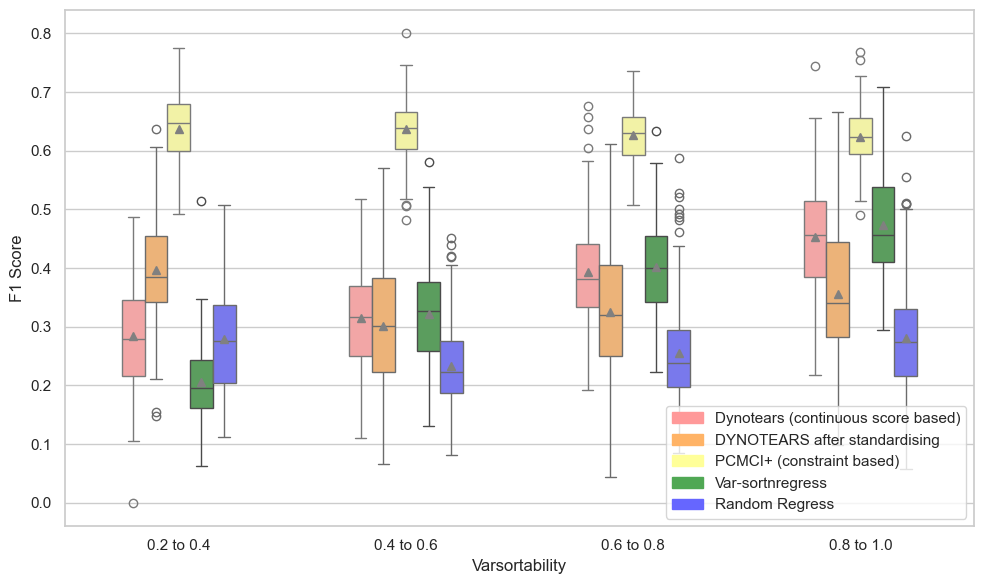

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="whitegrid")
# Assuming df is your DataFrame and it contains necessary columns


# Initialize the plot
plt.figure(figsize=(10, 6))

# Define boxplot colors and labels
boxplot_colors = ["#FF9999", "#FFB366", "#FFFF99", "#50A854", "#6666FF"]
boxplot_labels = [
    "Dynotears (continuous score based)",
    "DYNOTEARS after standardising",
    "PCMCI+ (constraint based)",
    "Var-sortnregress",
    "Random Regress",
]

# Initialize legend handles and labels lists
legend_handles = []
legend_labels = []

# Loop through each boxplot
for i, (color, label) in enumerate(zip(boxplot_colors, boxplot_labels)):
    sns.boxplot(
        data=df_,
        x="varsortability_bin",
        y=[
            "f1_dynotears",
            "f1_dynotears_standardized",
            "f1_pcmci+",
            "f1_var_sortnregress",
            "f1_random",
        ][i],
        showmeans=True,
        color=color,
        width=0.1,
        meanprops={"markerfacecolor": "grey", "markeredgecolor": "grey"},
        positions=np.arange(4) + (i - 2) * 0.1,  # Adjust position for each boxplot
    )
    # Append handles and labels for each boxplot to the legend lists
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
    legend_labels.append(label)

# Add legend with custom handles and labels
plt.legend(handles=legend_handles, labels=legend_labels, loc="lower right")

plt.xlabel("Varsortability")
plt.ylabel("F1 Score")

# Set xticks correctly round to 2 decimal places e.g 0 to 0.2
plt.xticks(
    np.arange(4),
    [
        f"{round(i.left, 2)} to {round(i.right, 2)}"
        for i in df["varsortability_bin"].cat.categories
    ],
)

plt.tight_layout()
plt.savefig("../../Figures/benchmark_var.pdf", dpi=500)
plt.show()

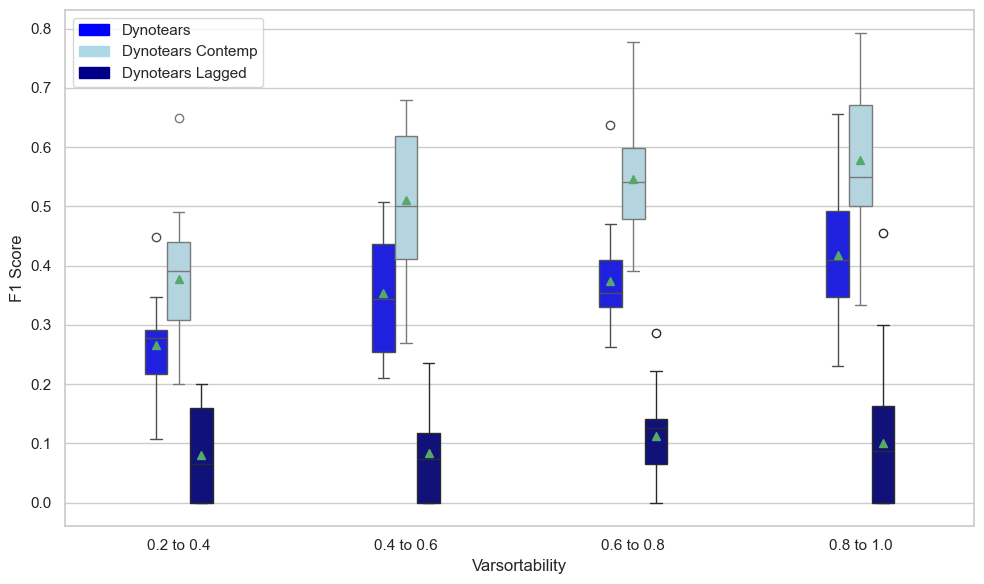

In [ ]:
# boxplot with all dynotears results contemporaneous, lagged and overall
plt.figure(figsize=(10, 6))
boxplot_colors = ["blue", "lightblue", "darkblue"]
boxplot_labels = ["Dynotears", "Dynotears Contemp", "Dynotears Lagged"]

legend_handles = []

legend_labels = []

for i, (color, label) in enumerate(zip(boxplot_colors, boxplot_labels)):
    sns.boxplot(
        data=df_,
        x="varsortability_bin",
        y=["f1_dynotears", "f1_dynotears_contemp", "f1_dynotears_lagged"][i],
        showmeans=True,
        color=color,
        width=0.1,
        positions=np.arange(4) + (i - 1) * 0.1,
    )
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
    legend_labels.append(label)

plt.legend(handles=legend_handles, labels=legend_labels, loc="upper left")

plt.xlabel("Varsortability")

plt.ylabel("F1 Score")

plt.xticks(
    np.arange(4),
    [
        f"{round(i.left, 2)} to {round(i.right, 2)}"
        for i in df["varsortability_bin"].cat.categories
    ],
)

plt.tight_layout()

plt.savefig("figures/benchmark_var_dyno.pdf", dpi=500)

In [ ]:
df["r2_sortability_bin"] = pd.cut(df["r2 sortability"], bins=np.arange(0.2, 1.1, 0.2))

set(df["r2_sortability_bin"].values)

{Interval(0.2, 0.4, closed='right'),
 Interval(0.4, 0.6, closed='right'),
 Interval(0.6, 0.8, closed='right'),
 Interval(0.8, 1.0, closed='right'),
 nan}

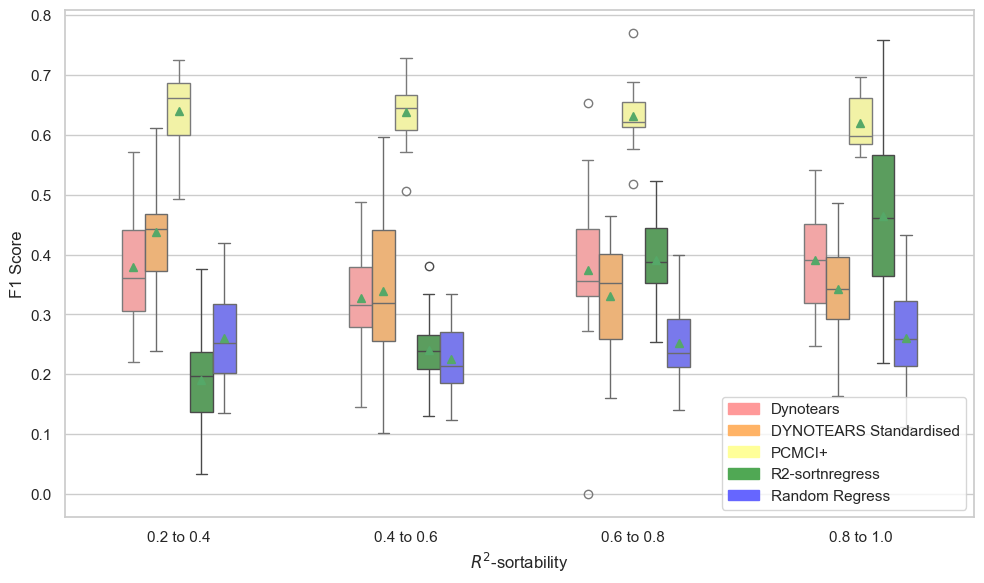

In [ ]:
# same for r2 sortability
df["r2_sortability_bin"] = pd.cut(df["r2 sortability"], bins=np.arange(0.2, 1.1, 0.2))

df_ = df.groupby("r2_sortability_bin").apply(lambda x: x.sample(n=18))

plt.figure(figsize=(10, 6))

# boxplot_colors = ["blue", "orange", "red", "green", "yellow"]


boxplot_colors = ["#FF9999", "#FFB366", "#FFFF99", "#50A854", "#6666FF"]
boxplot_labels = [
    "Dynotears",
    "DYNOTEARS Standardised",
    "PCMCI+",
    "R2-sortnregress",
    "Random Regress",
]

legend_handles = []
legend_labels = []

for i, (color, label) in enumerate(zip(boxplot_colors, boxplot_labels)):
    sns.boxplot(
        data=df_,
        x="r2_sortability_bin",
        y=[
            "f1_dynotears",
            "f1_dynotears_standardized",
            "f1_pcmci+",
            "f1_r2_sortnregress",
            "f1_random",
        ][i],
        showmeans=True,
        color=color,
        width=0.1,
        positions=np.arange(4) + (i - 2) * 0.1,
    )
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
    legend_labels.append(label)

plt.legend(handles=legend_handles, labels=legend_labels, loc="lower right")

plt.xlabel("$R^2$-sortability")

plt.ylabel("F1 Score")

plt.xticks(
    np.arange(4),
    [
        f"{round(i.left, 2)} to {round(i.right, 2)}"
        for i in df["r2_sortability_bin"].cat.categories
    ],
)

plt.tight_layout()
plt.savefig("../../Figures/benchmark_r2.pdf", dpi=500)
plt.show()

## Standardized

In [ ]:
results = {}

for n_nodes in [10, 20, 50, 100]:
    r2s = []
    r2s_contemp = []
    r2s_lagged = []
    var_sorts = []
    var_sorts_contemp = []
    var_sorts_lagged = []

    lin_f = lambda x: x

    for i in tqdm(range(500)):
        links_coeffs = generate_random_dag(
            n_nodes=n_nodes,
            d_intra=4,
            d_inter=1,
            tau_max=3,
            f=lin_f,
            graph_type="erdos-renyi",
        )

        T = 500

        noises = np.array(
            [
                (1.0 + 0.2 * float(j)) * np.random.randn((T + int(math.floor(0.2 * T))))
                for j in range(len(links_coeffs))
            ]
        ).T

        data, _ = toys.structural_causal_process(
            links_coeffs, T=T, noises=noises, seed=42
        )

        a_true = get_adj(links_coeffs=links_coeffs, tau_max=3)
        G = nx.DiGraph(ts_graph_to_summary_graph(a_true[:, :, 1:]))

        sum_adj = ts_graph_to_summary_graph(a_true)

        vars = var_sortability(data, sum_adj)
        r2 = r2_sortability(data, sum_adj)
        r2s.append(r2)
        var_sorts.append(vars)
        sum_adj = ts_graph_to_summary_graph(a_true[:, :, 1:])
        var_sorts_lagged.append(var_sortability(data, sum_adj))
        var_sorts_contemp.append(var_sortability(data, a_true[:, :, 0]))

        r2s_lagged.append(r2_sortability(data, sum_adj))

        r2s_contemp.append(r2_sortability(data, a_true[:, :, 0]))

        results[n_nodes] = {
            "var_sorts": var_sorts,
            "r2s": r2s,
            "r2s_contemp": r2s_contemp, 
            "r2s_lagged": r2s_lagged,
            "var_sorts_lagged": var_sorts_lagged,
            "var_sorts_contemp": var_sorts_contemp,
        }

100%|██████████| 500/500 [15:09<00:00,  1.82s/it]


Number of nodes: 10
var-sortability
$0.71 \pm 0.16$
$0.56 \pm 0.18$
$0.58 \pm 0.09$
r2-sortability
$0.54 \pm 0.22$
$0.49 \pm 0.18$
$0.51 \pm 0.10$
Number of nodes: 20
var-sortability
$0.72 \pm 0.12$
$0.54 \pm 0.13$
$0.56 \pm 0.06$
r2-sortability
$0.52 \pm 0.15$
$0.49 \pm 0.13$
$0.51 \pm 0.06$
Number of nodes: 50
var-sortability
$0.71 \pm 0.08$
$0.54 \pm 0.11$
$0.54 \pm 0.03$
r2-sortability
$0.50 \pm 0.12$
$0.50 \pm 0.11$
$0.50 \pm 0.03$
Number of nodes: 100
var-sortability
$0.72 \pm 0.06$
$0.54 \pm 0.10$
$0.54 \pm 0.02$
r2-sortability
$0.50 \pm 0.08$
$0.49 \pm 0.09$
$0.50 \pm 0.02$


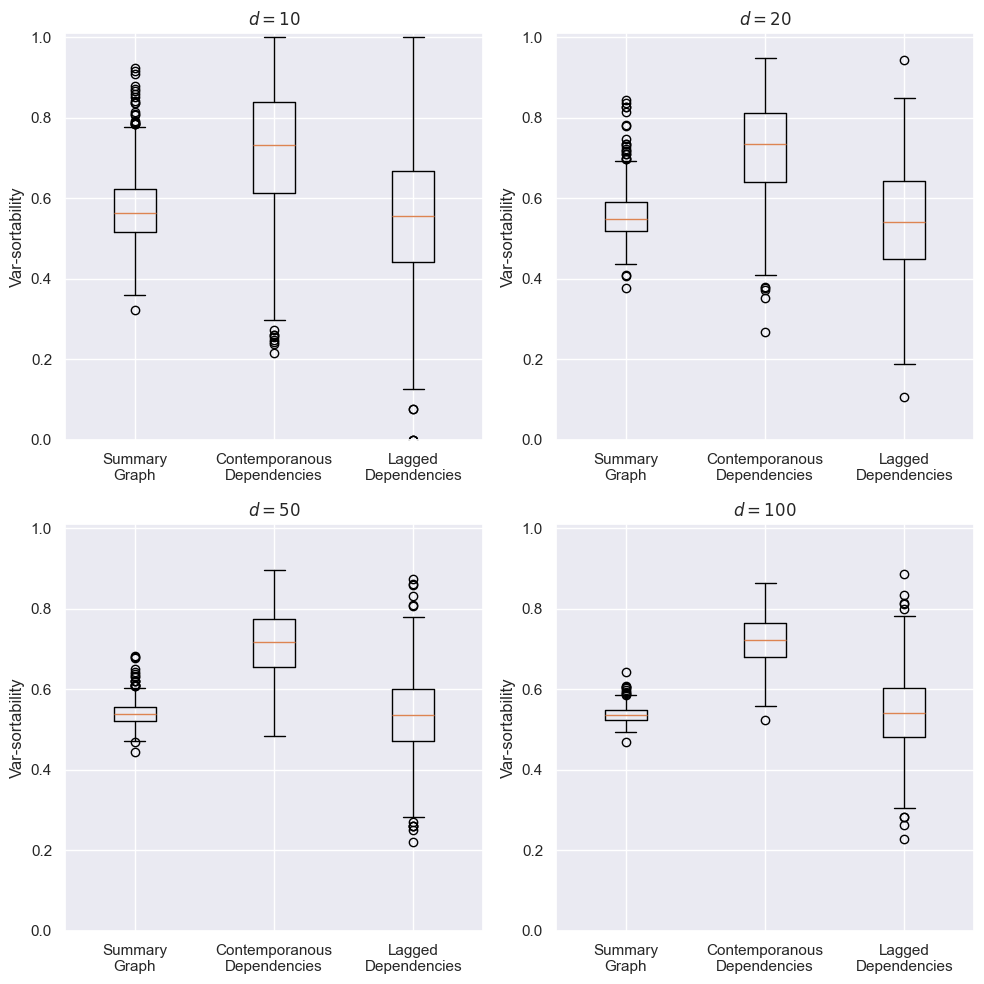

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
axs = axs.flatten()
sns.set_theme()
for i, n_nodes in enumerate([10, 20, 50, 100]):
    axs[i].boxplot(
        [
            results[n_nodes]["var_sorts"],
            results[n_nodes]["var_sorts_contemp"],
            results[n_nodes]["var_sorts_lagged"],
        ],
        labels=[
            "Summary\nGraph",
            "Contemporanous\nDependencies",
            "Lagged\nDependencies",
        ],
        vert=True,
    )
    axs[i].set_title(f"$d = {n_nodes}$")

    axs[i].set_ylim(0, 1.01)
    axs[i].set_ylabel("Var-sortability")

fig.tight_layout()  

# create a table with the results of the var-sortability instead of the boxplot

df = pd.DataFrame()

df["varsortability_10 nodes"] = results[10]["var_sorts"]
df["varsortability_20 nodes"] = results[20]["var_sorts"]
df["varsortability_50 nodes"] = results[50]["var_sorts"]
df["varsortability_100 nodes"] = results[100]["var_sorts"]

df["varsortability_10 nodes_contemp"] = results[10]["var_sorts_contemp"]
df["varsortability_20 nodes_contemp"] = results[20]["var_sorts_contemp"]
df["varsortability_50 nodes_contemp"] = results[50]["var_sorts_contemp"]
df["varsortability_100 nodes_contemp"] = results[100]["var_sorts_contemp"]

df["varsortability_10 nodes_lagged"] = results[10]["var_sorts_lagged"]
df["varsortability_20 nodes_lagged"] = results[20]["var_sorts_lagged"]
df["varsortability_50 nodes_lagged"] = results[50]["var_sorts_lagged"]
df["varsortability_100 nodes_lagged"] = results[100]["var_sorts_lagged"]


# only show the mean and std of the var-sortability and var-sortability contemporaneous

# print the mean and std of the var-sortability and var-sortability contemporaneous for each number of nodes
for n_nodes in [10, 20, 50, 100]:

    
    print(f"Number of nodes: {n_nodes}")

    print("var-sortability")
    print(
        f"${np.mean(results[n_nodes]['var_sorts_contemp']):.2f} \pm {np.std(results[n_nodes]['var_sorts_contemp']):.2f}$"
    )
    # laggged
    print(
        f"${np.mean(results[n_nodes]['var_sorts_lagged']):.2f} \pm {np.std(results[n_nodes]['var_sorts_lagged']):.2f}$"
    )
    # print mean riunded two two decimal \pm std rounded to two decimal places
    print(
        f"${np.mean(results[n_nodes]['var_sorts']):.2f} \pm {np.std(results[n_nodes]['var_sorts']):.2f}$"
    )
    # same for r2 sortability§
    print("r2-sortability")

    print(
        f"${np.mean(results[n_nodes]['r2s_contemp']):.2f} \pm {np.std(results[n_nodes]['r2s_contemp']):.2f}$"
    )

    print(
        f"${np.mean(results[n_nodes]['r2s_lagged']):.2f} \pm {np.std(results[n_nodes]['r2s_lagged']):.2f}$"
    )

    print(
        f"${np.mean(results[n_nodes]['r2s']):.2f} \pm {np.std(results[n_nodes]['r2s']):.2f}$"
    )


In [ ]:


df = pd.DataFrame()

df["varsortability_10 nodes"] = results[10]["var_sorts"]


varsortability_10 nodes  varsortability_20 nodes  \
0                   0.495431                 0.585194   
1                   0.476692                 0.576507   
2                   0.529528                 0.574887   
3                   0.863248                 0.595425   
4                   0.602740                 0.480450   
..                       ...                      ...   
495                 0.597458                 0.529692   
496                 0.489736                 0.597180   
497                 0.701887                 0.559169   
498                 0.542143                 0.572943   
499                 0.572816                 0.655094   

     varsortability_50 nodes  varsortability_100 nodes  \
0                   0.545004                  0.549625   
1                   0.517219                  0.545391   
2                   0.498022                  0.541838   
3                   0.510082                  0.521313   
4                   0.560076                  0.540259   
..                       ...                       ...   
495                 0.533254                  0.570320   
496                 0.485912                  0.553631   
497                 0.545971                  0.521846   
498                 0.657478                  0.562226   
499                 0.539734                  0.498068   

     varsortability_10 nodes_contemp  varsortability_20 nodes_contemp  \
0                           0.507463                         0.725118   
1                           0.842105                         0.748954   
2                           0.921053                         0.731481   
3                           0.787234                         0.821429   
4                           0.625000                         0.626866   
..                               ...                              ...   
495                         0.710526                         0.816901   
496                         0.853659                         0.771930   
497                         0.768116                         0.573991   
498                         0.648148                         0.881818   
499                         0.934783                         0.912088   

     varsortability_50 nodes_contemp  varsortability_100 nodes_contemp  
0                           0.735759                          0.757927  
1                           0.744027                          0.744975  
2                           0.538721                          0.541880  
3                           0.688654                          0.804348  
4                           0.715294                          0.775223  
..                               ...                               ...  
495                         0.787307                          0.624674  
496                         0.718232                          0.734864  
497                         0.819222                          0.819620  
498                         0.827160                          0.741821  
499                         0.734266                          0.704607  

[500 rows x 8 columns]

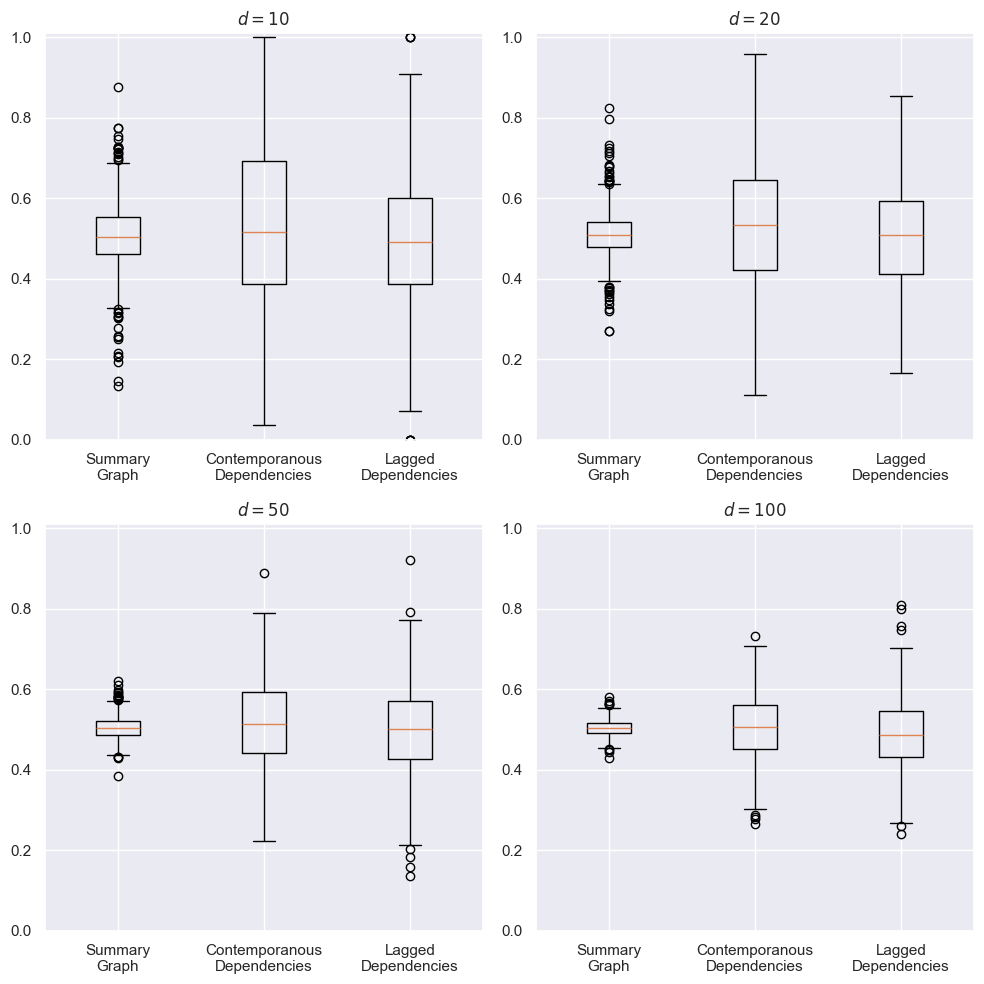

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
axs = axs.flatten()

for i, n_nodes in enumerate([10, 20, 50, 100]):
    axs[i].boxplot(
        [
            results[n_nodes]["r2s"],
            results[n_nodes]["r2s_contemp"],
            results[n_nodes]["r2s_lagged"],
        ],
        labels=[
            "Summary\nGraph",
            "Contemporanous\nDependencies",
            "Lagged\nDependencies",
        ],
        vert=True,
    )
    axs[i].set_title(f"$d = {n_nodes}$")
    axs[i].set_ylim(0, 1.01)
    axs[i].set_ylabel("$r^2$-sortability")
fig.tight_layout()

In [ ]:
type(var_sorts)
var_sorts = np.array(var_sorts)
var_sorts_lagged = np.array(var_sorts_lagged)

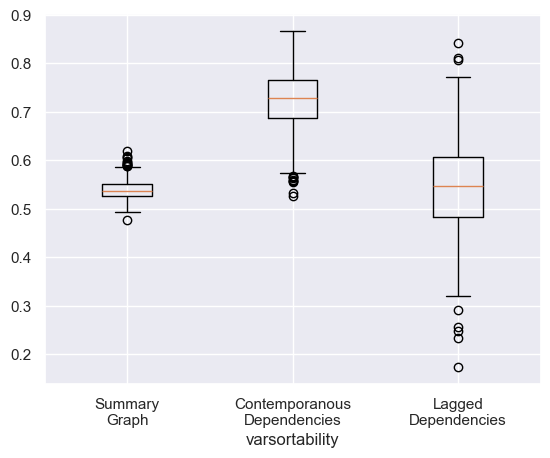

In [ ]:
var_sorts_lagged = np.array(var_sorts_lagged)
var_sorts_lagged = var_sorts_lagged[~np.isnan(var_sorts_lagged)]

var_sorts = var_sorts[~np.isnan(var_sorts)]

plt.boxplot(
    [var_sorts, var_sorts_contemp, var_sorts_lagged],
    labels=["Summary\nGraph", "Contemporanous\nDependencies", "Lagged\nDependencies"],
    vert=True,
)

plt.xlabel("varsortability")

plt.show()

In [ ]:
degrees = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2]
results = {}
for degree in degrees:
    r2s = []
    variances = []
    f1_dynotears = []

    lin_f = lambda x: x

    for i in tqdm(range(500)):
        links_coeffs = generate_random_dag(
            n_nodes=10,
            d_intra=4,
            d_inter=degree,
            tau_max=3,
            f=lin_f,
        )

        T = 1000

        noises = np.array(
            [
                (1.0 + 0.2 * float(j)) * np.random.randn((T + int(math.floor(0.2 * T))))
                for j in range(len(links_coeffs))
            ]
        ).T

        data, _ = toys.structural_causal_process(links_coeffs, T=T, noises=noises, seed=42)

        a_true = get_adj(links_coeffs=links_coeffs, tau_max=3)

        sum_adj = ts_graph_to_summary_graph(a_true)


        vars = var_sortability(data, sum_adj)
        variances.append(vars)
    variances = np.array(variances)
    variances = variances[~np.isnan(variances)]

    q1 = np.percentile(variances, 25)
    q3 = np.percentile(variances, 75)

    results[degree] = variances

 92%|█████████▏| 460/500 [00:21<00:01, 22.23it/s]/Users/christopher/Library/Caches/pypoetry/virtualenvs/praktikum_tu-VDxEGQcM-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/var/folders/82/3xkyvrsn2y5c1r9rbchxcfbc0000gn/T/ipykernel_33443/451010190.py:28: RuntimeWarning: invalid value encountered in subtract
  differences = scores - scores.T
 10%|▉         | 48/500 [00:02<00:25, 17.48it/s]/Users/christopher/Library/Caches/pypoetry/virtualenvs/praktikum_tu-VDxEGQcM-py3.10/lib/python3.10/site-packages/tigramite-5.2.3.2-py3.10.egg/tigramite/toymodels/structural_causal_processes.py:773: RuntimeWarning: invalid value encountered in double_scalars
/Users/christopher/Library/Caches/pypoetry/virtualenvs/praktikum_tu-VDxEGQcM-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=wh

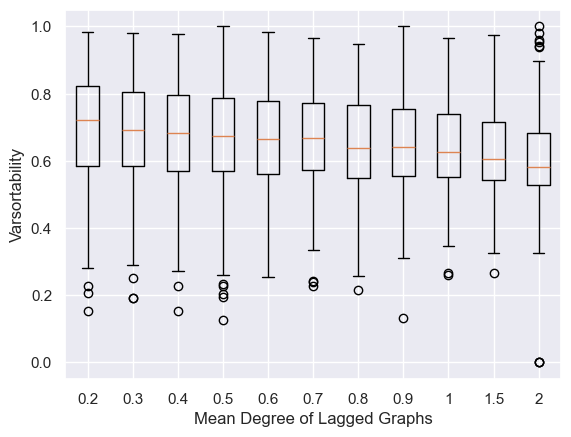

In [ ]:
plt.boxplot(results.values(), labels= results.keys())
plt.xlabel("Mean Degree of Lagged Graphs")
plt.ylabel("Varsortability")
plt.show()

In [ ]:
lin_f = lambda x: x

links_coeffs = {
    0: [((0, -1), 0.7, lin_f)],
    1: [((1, -1), 0.5, lin_f), ((0, 0), 0.3, lin_f)],
    2: [((2, -1), 0.5, lin_f), ((0, -1), 0.5, lin_f)],
    3: [((3, -1), 0.0, lin_f)],
    4: [((4, -1), 0.0, lin_f), ((3, -1), 0.7, lin_f)],  # , ((3, -1), 0.3, lin_f)],
}
T = 500
noises = np.array(
        [
            (1.0 + 0.2 * float(j)) * np.random.randn((T + int(math.floor(0.2 * T))))
            for j in range(len(links_coeffs))
        ]
    ).T
data, _ = toys.structural_causal_process(links_coeffs, T=T, noises=noises, seed=42)
var_names = [r"$X^0$", r"$X^1$", r"$X^2$", r"$X^3$", r"$X^4$"]
mask = None

dataframe = pp.DataFrame(
    data, mask=mask, datatime={0: np.arange(len(data))}, var_names=var_names
)

dynotears = Dynotears(dataframe=dataframe)
w_est, _, graph, a_est_dyno = dynotears.run_dynotears(
    tau_max=5, max_iter=100, w_threshold=0.1, lambda_a=0.1, lambda_w=0.1
)

a_true = get_adj(links_coeffs=links_coeffs, tau_max=2)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

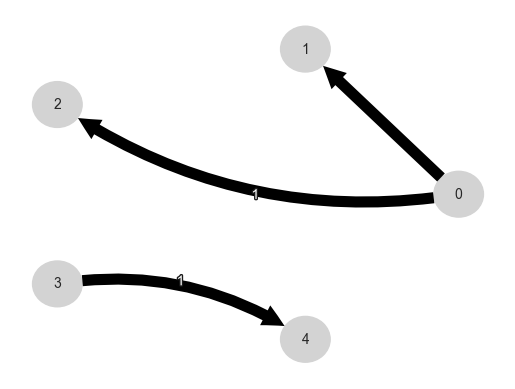

In [ ]:
sum_adj = ts_graph_to_summary_graph(a_true)

tp.plot_graph(a_true,)

In [ ]:
sum_adj

array([[0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

In [ ]:
var_sortability(data, sum_adj)


1.0

In [ ]:
r2_sortability(data, sum_adj)

0.0

In [ ]:
a_est_sortnreg = sortnregress_ts(data, tau_max=2)

In [ ]:
dynotears = Dynotears(dataframe=dataframe)
w_est, _, graph, a_est_dyno = dynotears.run_dynotears(
    tau_max=2, max_iter=100, w_threshold=0.01, lambda_a=0.05, lambda_w=0.05
)

Text(0.5, 1.0, 'PCMCI')

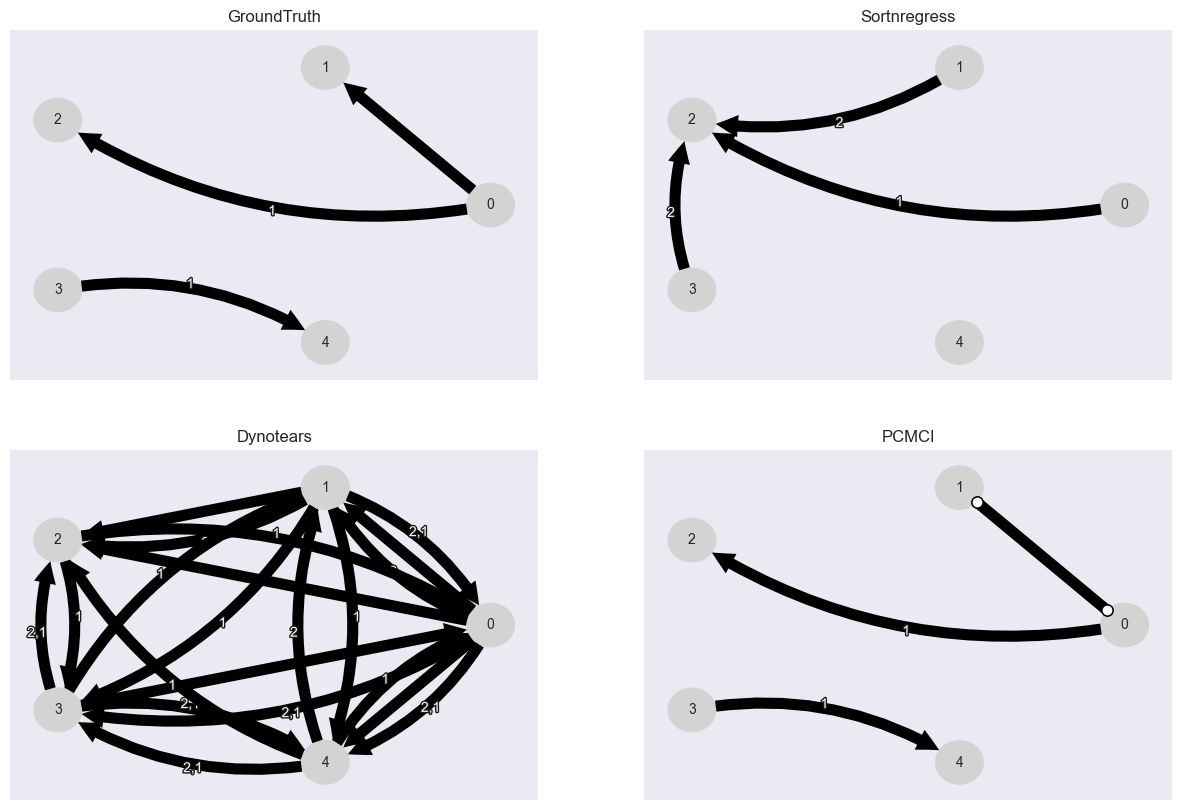

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
tp.plot_graph(a_true, fig_ax=(fig, ax[0]))
tp.plot_graph(a_est_sortnreg, fig_ax=(fig, ax[1]))
tp.plot_graph(a_est_dyno, fig_ax=(fig, ax[2]))
tp.plot_graph(results["graph"],  fig_ax=(fig, ax[3]))

ax[0].set_title("GroundTruth")
ax[1].set_title("Sortnregress")
ax[2].set_title("Dynotears")
ax[3].set_title("PCMCI")

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = scaler.fit_transform(data)


dataframe = pp.DataFrame(
    data, mask=mask, datatime={0: np.arange(len(data))}, var_names=var_names
)

In [ ]:
var_sortability(data, sum_adj)

0.5

In [ ]:
r2_sortability(data, sum_adj)

0.0

In [ ]:
parcorr = ParCorr(
    significance="analytic",
    #                   mask_type='y'
)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)
results = pcmci.run_pcmciplus(tau_max=2, pc_alpha=0.01)

a_est_sortnreg = sortnregress_ts(data, tau_max=2)

dynotears = Dynotears(dataframe=dataframe)
w_est, _, graph, a_est_dyno = dynotears.run_dynotears(
    tau_max=2, max_iter=100, w_threshold=0.01, lambda_a=0.05, lambda_w=0.05
)

Text(0.5, 1.0, 'PCMCI')

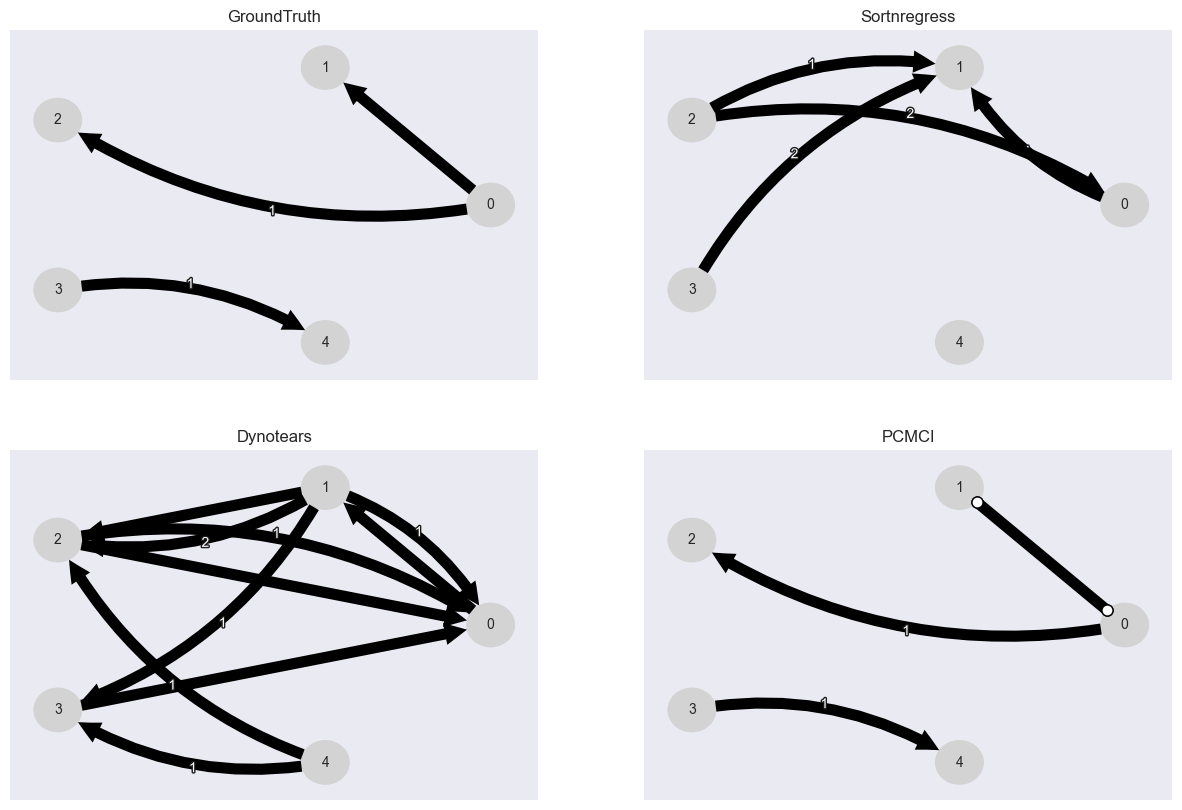

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
tp.plot_graph(a_true, fig_ax=(fig, ax[0]))
tp.plot_graph(a_est_sortnreg, fig_ax=(fig, ax[1]))
tp.plot_graph(a_est_dyno, fig_ax=(fig, ax[2]))
tp.plot_graph(results["graph"] , fig_ax=(fig, ax[3]))

ax[0].set_title("GroundTruth")
ax[1].set_title("Sortnregress")
ax[2].set_title("Dynotears")
ax[3].set_title("PCMCI")

Text(0.5, 1.0, 'PCMCI')

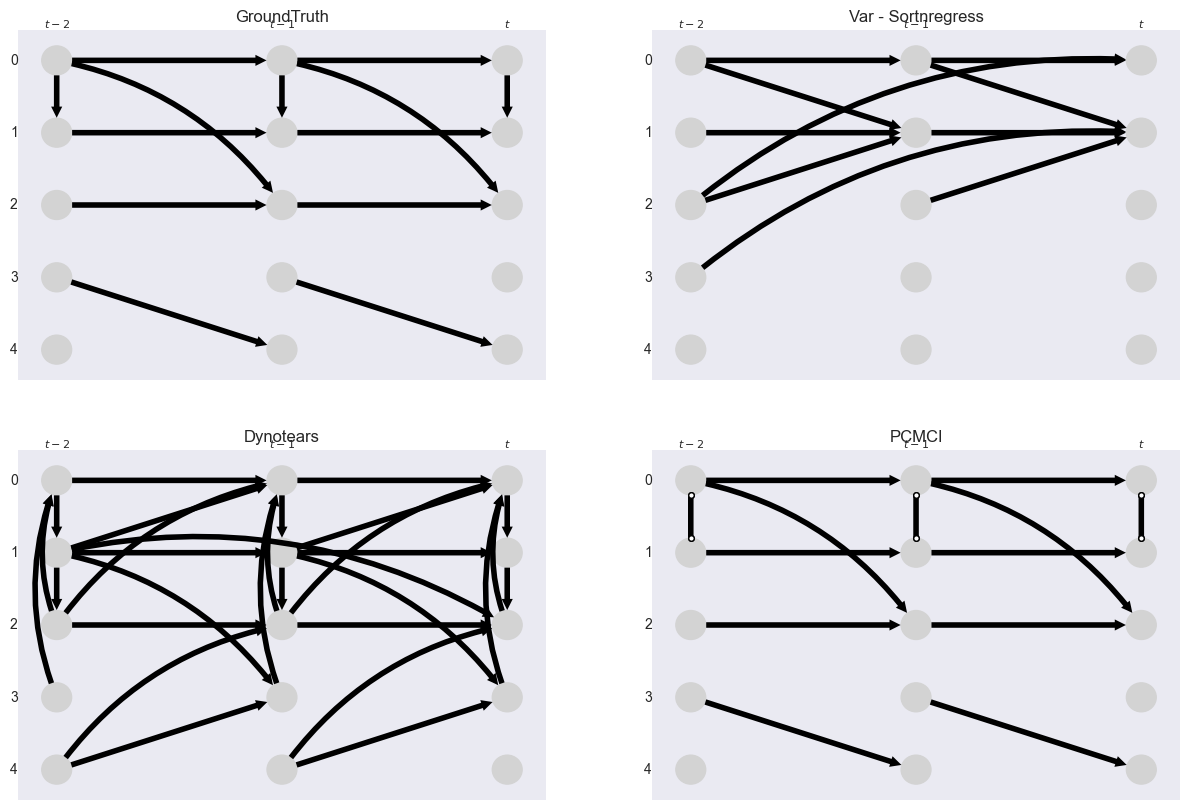

In [ ]:
eeeefig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
tp.plot_time_series_graph(a_true, fig_ax=(fig, ax[0]))
tp.plot_time_series_graph(a_est_sortnreg, fig_ax=(fig, ax[1]))
tp.plot_time_series_graph(a_est_dyno, fig_ax=(fig, ax[2]))
tp.plot_time_series_graph(results["graph"], fig_ax=(fig, ax[3]))

ax[0].set_title("GroundTruth")
ax[1].set_title("Var - Sortnregress")
ax[2].set_title("Dynotears")
ax[3].set_title("PCMCI")

In [ ]:
def run_experiments(n_runs, n_set_ups, set_up_config):

    for i in range(n_runs):
        for setup in set_up_config:
            pass


In [ ]:
import cdt

cdt.SETTINGS.rpath = "/usr/local/bin/R"

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [ ]:
from cdt.metrics import precision_recall

a_est_dyno[a_est_dyno != 0] = 1
a_true[a_true != 0] = 1
aupr, curve = precision_recall(a_est_dyno, a_true)

aupr

0.5471794871794871

In [ ]:
a_est_sortnreg[a_est_sortnreg != 0] = 1
aupr, curve = precision_recall(a_est_sortnreg, a_true)

aupr

0.36

In [ ]:
import pandas as pd

In [ ]:
d_contemp = [0, 0.5, 1, 2, 3, 4]
d_lagged = [0, 0.5, 1, 2, 3, 4]

In [ ]:
d_contemp = [0, 0.5, 1, 2, 3, 4]
d_lagged = [0, 0.5, 1, 2, 3, 4]

var_sorts_degree = {}
r_2_sorts_degree = {}
var_sorts = []
r2_sorts = []
for d_c in  d_contemp:
    for d_l in d_lagged:
        if d_c == 0 and d_l == 0:
            continue
        var_sorts = []
        r2_sorts = []
        for i in tqdm(range(500)):
            links_coeffs = generate_random_dag(
                n_nodes=5,
                d_intra=d_c,
                d_inter=d_l,
                tau_max=3,
                f=lin_f,
                graph_type="erdos-renyi",
            )

            T = 500

            noises = np.array(
                [
                    (1.0 + 0.2 * float(j)) * np.random.randn((T + int(math.floor(0.2 * T))))
                    for j in range(len(links_coeffs))
                ]
            ).T

            data, _ = toys.structural_causal_process(links_coeffs, T=T, noises=noises, seed=42)


            shape = data.shape

            data = pd.DataFrame(data)


            data.dropna(inplace= True)

            # Drop rows containing infinity values
            data = data[~data.isin([np.inf, -np.inf]).any(axis=1)]

            data = data.to_numpy()

            a_true = get_adj(links_coeffs=links_coeffs, tau_max=3)
            G = nx.DiGraph(ts_graph_to_summary_graph(a_true[:, :, 1:]))

            sum_adj = ts_graph_to_summary_graph(a_true)


            vars = var_sortability(data, sum_adj)
            r2 = r2_sortability(data, sum_adj)
            var_sorts.append(vars)
            r2_sorts.append(r2)

        var_sorts_degree[(d_c, d_l)] = var_sorts
        r_2_sorts_degree[(d_c, d_l)] = r2_sorts

100%|██████████| 500/500 [00:10<00:00, 47.94it/s]


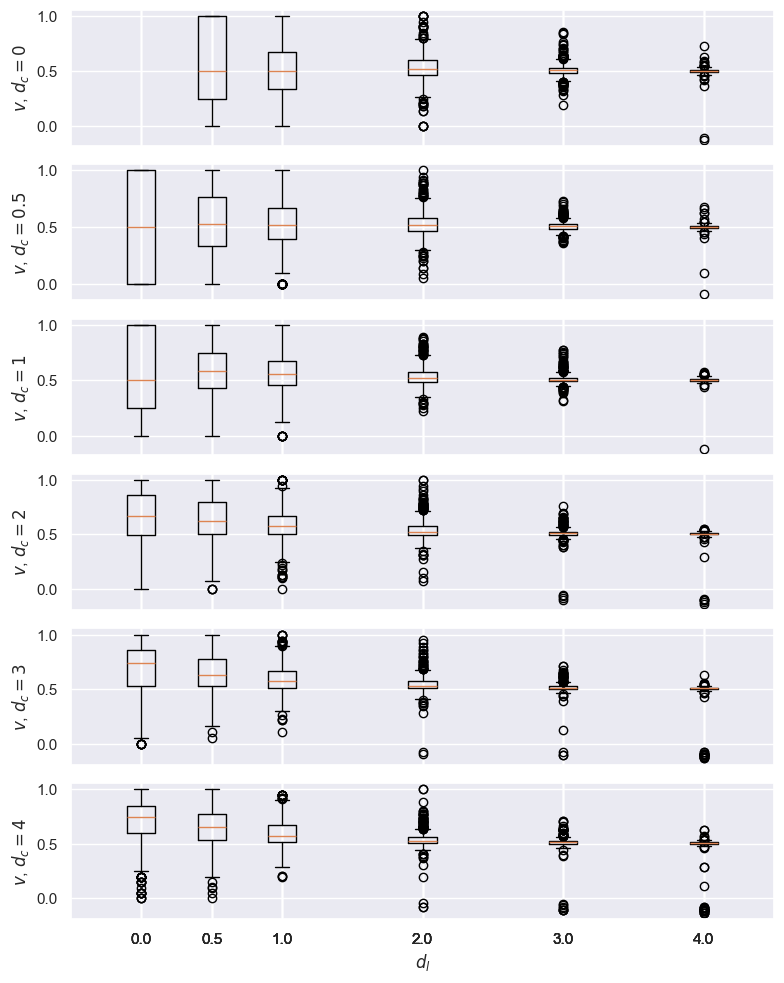

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme()

def plot_errorbars(data_dict, d_contemp_vals, d_lagged_vals, data_label):
    fig, axs = plt.subplots(len(d_contemp_vals), 1, figsize=(8, 10), sharex=True)

    for i, d_c in enumerate(d_contemp_vals):
        box_data = []
        x_ticks = []
        for j, d_l in enumerate(d_lagged_vals):
            if not (d_l, d_c) == (0, 0):
                # Remove NaN values
                filtered_data = [value for value in data_dict[(d_c, d_l)] if not np.isnan(value)]
                box_data.append(filtered_data)
                x_ticks.append(d_l)
        axs[i].boxplot(box_data, positions=x_ticks, widths=0.2)
        # axs[i].set_ylim(0, 1)  # Set y-axis limits from 0 to 1
        axs[i].set_ylabel(f"$v$, $d_c = {d_c}$")

    axs[i].set_xlabel("$d_l$")

    plt.tight_layout()
    plt.show()


plot_errorbars(var_sorts_degree, d_contemp, d_lagged, "varsortability")

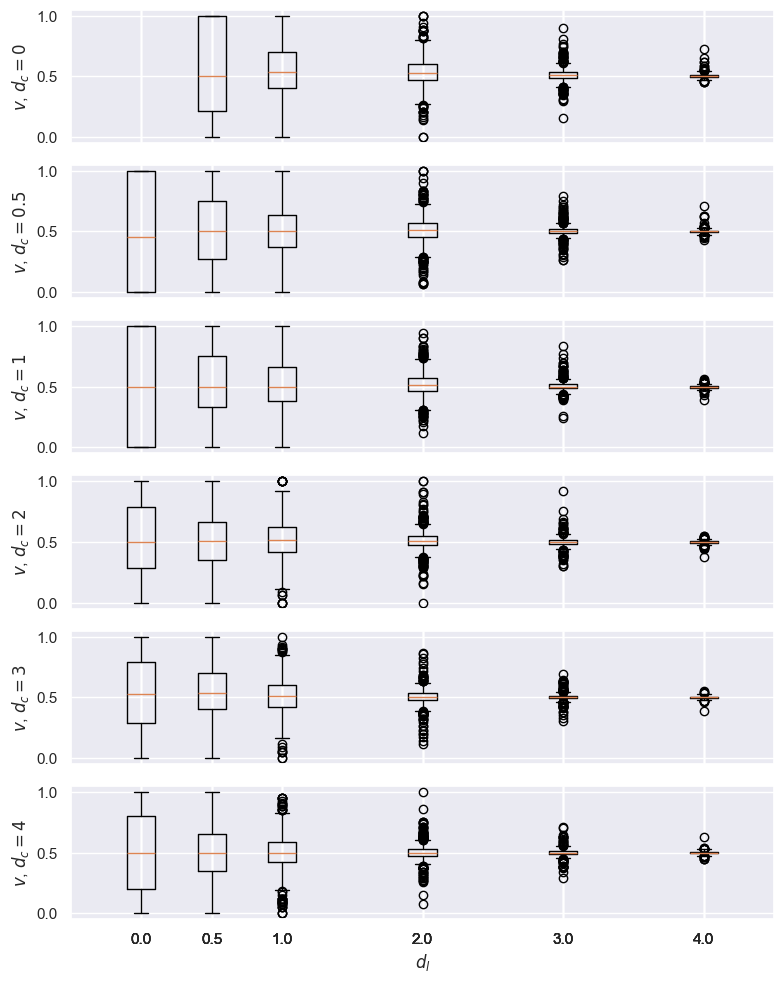

In [ ]:
# Plot error bars for r2_sorts
plot_errorbars(r_2_sorts_degree, d_contemp, d_lagged, "$r^2-sortability")

## n = 10

In [ ]:
d_contemp = [0, 0.5, 1, 2, 3, 4, 6, 8, 10]
d_lagged = [0, 0.5, 1, 2, 3, 4, 6, 8, 10]

var_sorts_degree_10 = {}
r_2_sorts_degree_10 = {}
var_sorts = []
r2_sorts = []
for d_c in d_contemp:
    for d_l in d_lagged:
        if d_c == 0 and d_l == 0:
            continue
        var_sorts = []
        r2_sorts = []
        for i in tqdm(range(500)):
            links_coeffs = generate_random_dag(
                n_nodes=10,
                d_intra=d_c,
                d_inter=d_l,
                tau_max=3,
                f=lin_f,
                graph_type="erdos-renyi",
            )

            T = 500

            noises = np.array(
                [
                    (1.0 + 0.2 * float(j))
                    * np.random.randn((T + int(math.floor(0.2 * T))))
                    for j in range(len(links_coeffs))
                ]
            ).T

            data, _ = toys.structural_causal_process(
                links_coeffs, T=T, noises=noises, seed=42
            )

            shape = data.shape

            data = pd.DataFrame(data)

            data.dropna(inplace=True)

            # Drop rows containing infinity values
            data = data[~data.isin([np.inf, -np.inf]).any(axis=1)]

            data = data.to_numpy()

            a_true = get_adj(links_coeffs=links_coeffs, tau_max=3)
            G = nx.DiGraph(ts_graph_to_summary_graph(a_true[:, :, 1:]))

            sum_adj = ts_graph_to_summary_graph(a_true)

            vars = var_sortability(data, sum_adj)
            r2 = r2_sortability(data, sum_adj)
            var_sorts.append(vars)
            r2_sorts.append(r2)

        var_sorts_degree_10[(d_c, d_l)] = var_sorts
        r_2_sorts_degree_10[(d_c, d_l)] = r2_sorts

100%|██████████| 500/500 [00:47<00:00, 10.47it/s]


In [ ]:
import json
data_str_keys = {str(k): v for k, v in var_sorts_degree_10.items()}
file_path = "var_sorts_degree_10.json"

# Write dictionary to JSON file
with open(file_path, "w") as json_file:
    json.dump(data_str_keys, json_file, indent=4)

print("Data has been written to", file_path)

Data has been written to var_sorts_degree_10.json


In [ ]:
data_str_keys = {str(k): v for k, v in r_2_sorts_degree_10.items()}

file_path = "r_2_sorts_degree_10.json"

# Write dictionary to JSON file
with open(file_path, "w") as json_file:
    json.dump(data_str_keys, json_file, indent=4)

print("Data has been written to", file_path)

Data has been written to r_2_sorts_degree_10.json


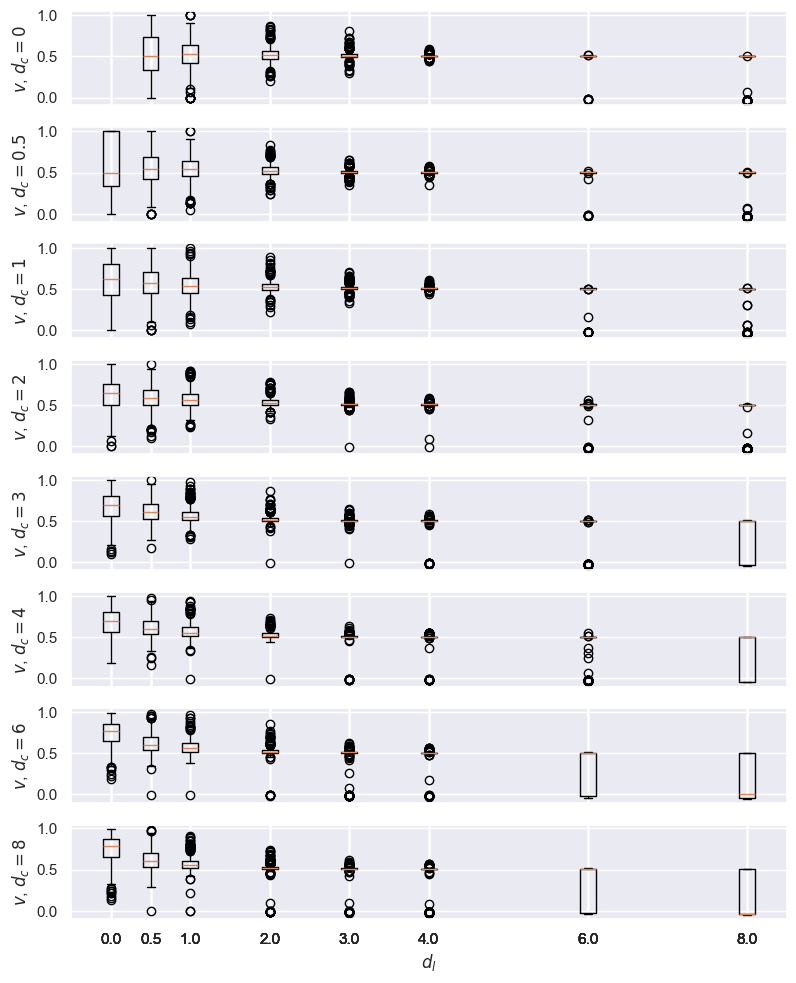

In [ ]:
d_contemp = [0, 0.5, 1, 2, 3, 4, 6, 8]
d_lagged = [0, 0.5, 1, 2, 3, 4, 6, 8]


plot_errorbars(var_sorts_degree_10, d_contemp, d_lagged, "varsortability")

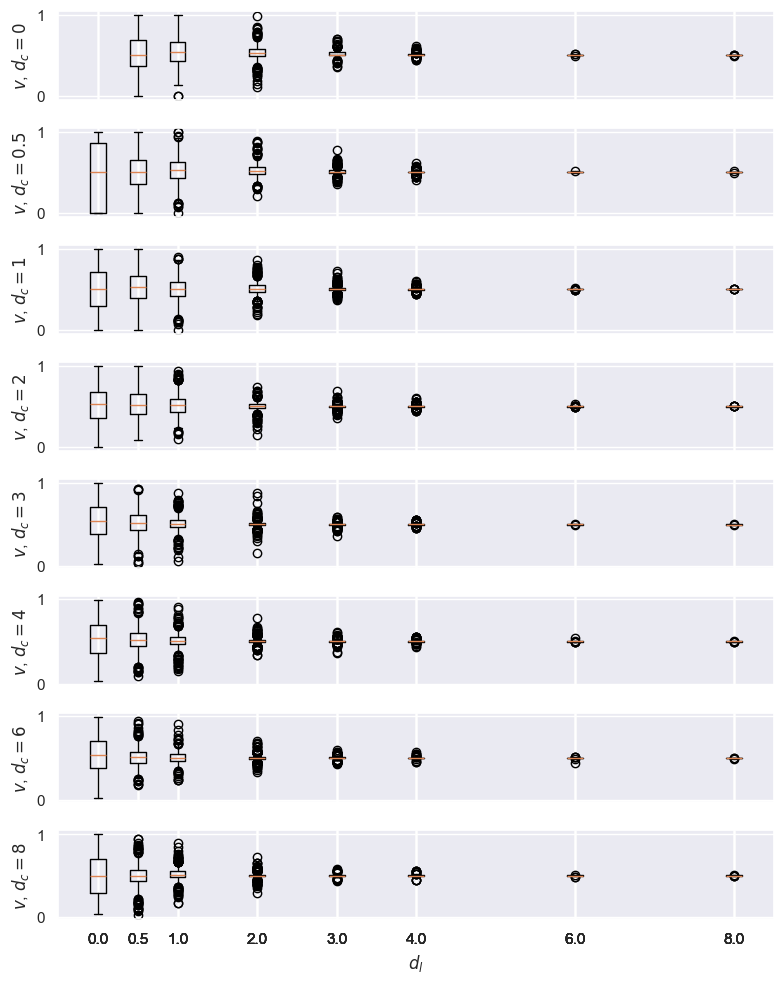

In [ ]:
plot_errorbars(r_2_sorts_degree_10, d_contemp, d_lagged, "$r^2-sortability")

In [ ]:
d_contemp = [0, 0.5, 1, 2, 3, 4, 6, 8]
d_lagged = [0, 0.5, 1, 2, 3, 4, 6, 8]

var_sorts_degree_20 = {}
r_2_sorts_degree_20 = {}
var_sorts = []
r2_sorts = []
for d_c in d_contemp:
    for d_l in d_lagged:
        if d_c == 0 and d_l == 0:
            continue
        var_sorts = []
        r2_sorts = []
        for i in tqdm(range(500)):
            links_coeffs = generate_random_dag(
                n_nodes=10,
                d_intra=d_c,
                d_inter=d_l,
                tau_max=3,
                f=lin_f,
                graph_type="erdos-renyi",
            )

            T = 500

            noises = np.array(
                [
                    (1.0 + 0.2 * float(j))
                    * np.random.randn((T + int(math.floor(0.2 * T))))
                    for j in range(len(links_coeffs))
                ]
            ).T

            data, _ = toys.structural_causal_process(
                links_coeffs, T=T, noises=noises, seed=42
            )

            shape = data.shape

            data = pd.DataFrame(data)

            data.dropna(inplace=True)

            # Drop rows containing infinity values
            data = data[~data.isin([np.inf, -np.inf]).any(axis=1)]

            data = data.to_numpy()

            a_true = get_adj(links_coeffs=links_coeffs, tau_max=3)
            G = nx.DiGraph(ts_graph_to_summary_graph(a_true[:, :, 1:]))

            sum_adj = ts_graph_to_summary_graph(a_true)


            vars = var_sortability(data, sum_adj)
            r2 = r2_sortability(data, sum_adj)
            var_sorts.append(vars)
            r2_sorts.append(r2)

        var_sorts_degree_20[(d_c, d_l)] = var_sorts
        r_2_sorts_degree_20[(d_c, d_l)] = r2_sorts

100%|██████████| 500/500 [00:40<00:00, 12.46it/s]


In [ ]:

data_str_keys = {str(k): v for k, v in var_sorts_degree_20.items()}

file_path = "var_sorts_degree_20.json"

# Write dictionary to JSON file
with open(file_path, "w") as json_file:
    json.dump(data_str_keys, json_file, indent=4)


data_str_keys = {str(k): v for k, v in r_2_sorts_degree_20.items()}
file_path = "r_2_sorts_degree_20.json"

# Write dictionary to JSON file
with open(file_path, "w") as json_file:
    json.dump(data_str_keys, json_file, indent=4)
    

In [ ]:
d_contemp = [0, 0.5, 1, 2, 3, 4, 6, 8]
d_lagged = [0, 0.5, 1, 2, 3, 4, 6, 8]

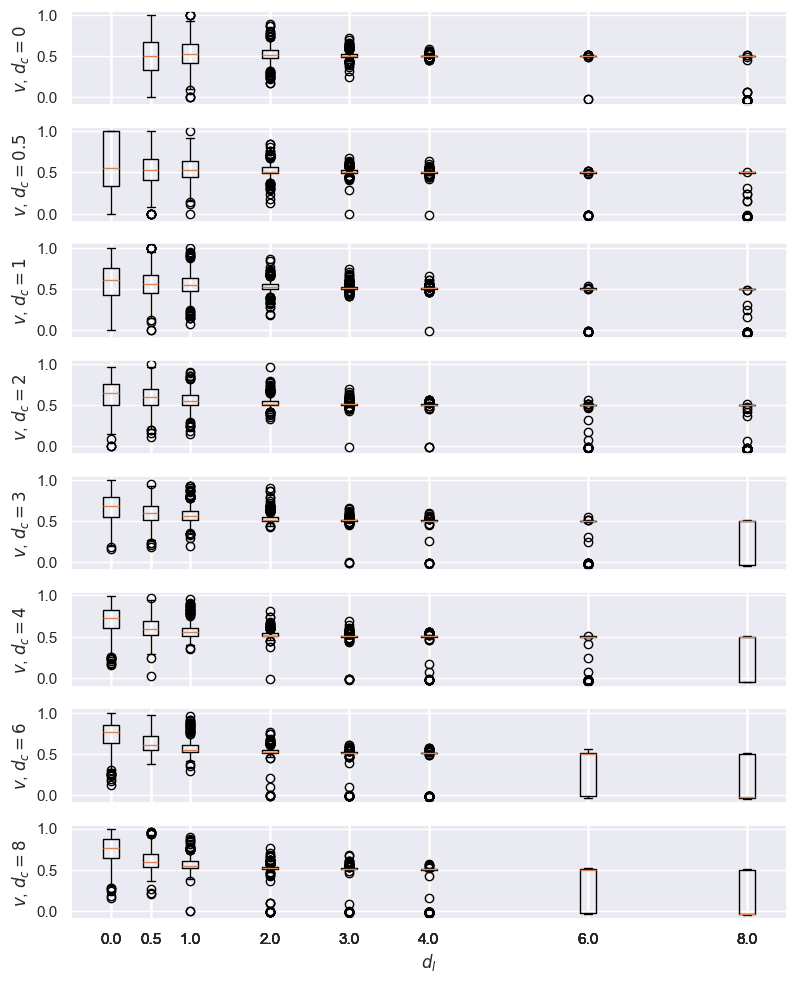

In [ ]:
plot_errorbars(var_sorts_degree_20, d_contemp, d_lagged, "varsortability")

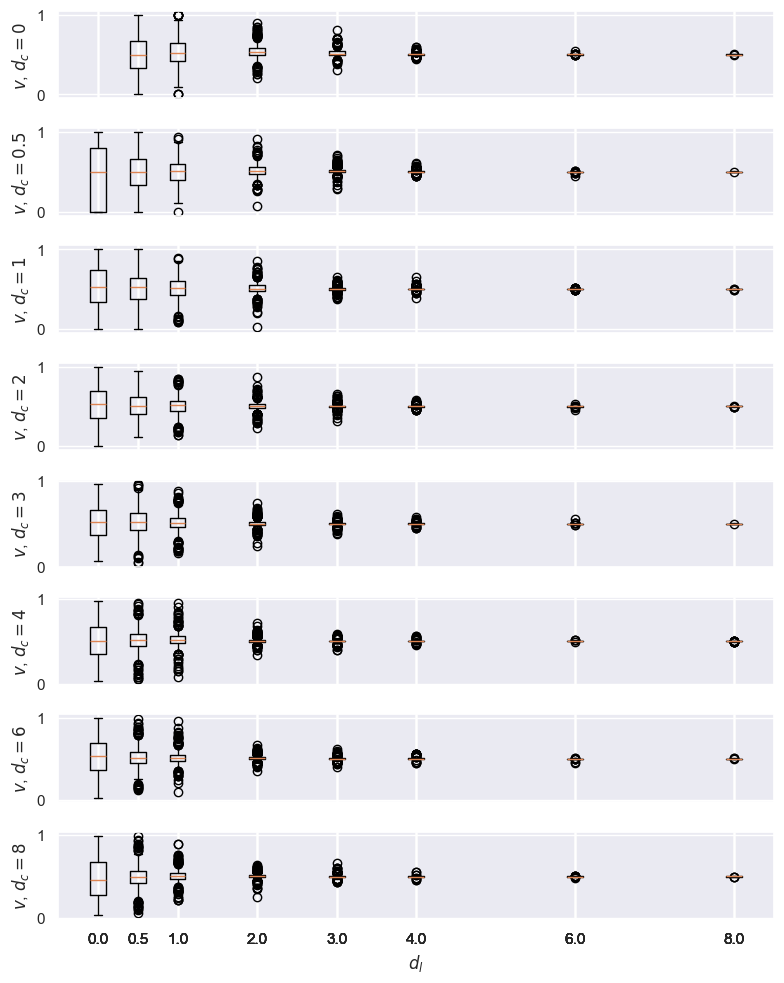

In [ ]:
plot_errorbars(r_2_sorts_degree_20, d_contemp, d_lagged, "$r^2-sortability")